<a href="https://colab.research.google.com/github/feliciahf/data_science_exam/blob/main/Hippocorpus_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERT

Code adapted from [BERT Tutorial](https://colab.research.google.com/drive/1pTuQhug6Dhl9XalKB0zUGf4FIdYFlpcX?fbclid=IwAR1Ho0ppZWAMksjLMoT8ArbedxcgFIrbR2D3GBMb7-wpu9lV7lnlUiq7bzE#scrollTo=EKOTlwcmxmej)

## Import Packages & Set Up GPU

In [16]:
!pip install tensorflow
!pip install transformers

In [17]:
import tensorflow as tf
import torch
import pandas as pd
import numpy as np
import time
import datetime
import random

# model
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler

# plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# accuracies
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report, matthews_corrcoef

In [18]:
# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [19]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


## Download & Extract Data

In [20]:
# import csv file as dataframe (from GitHub repo)
url = 'https://raw.githubusercontent.com/feliciahf/data_science_exam/main/hippoCorpusV2.csv'
df = pd.read_csv(url, encoding='latin1')

In [21]:
# remove retold category
df = df[df.memType != 'retold']

In [22]:
# make labels column using numerical values
df.memType = pd.Categorical(df.memType)
df['label'] = df.memType.cat.codes

# story type corresponding to label
print(f"Label 0: {df.loc[df['label'] == 0,'memType'].unique()}")
print(f"Label 1: {df.loc[df['label'] == 1,'memType'].unique()}")

Label 0: ['imagined']
Categories (1, object): ['imagined']
Label 1: ['recalled']
Categories (1, object): ['recalled']


# Preprocessing

## Split Data

In [23]:
df['split'] = np.random.randn(df.shape[0],1)

# create mask to split data into 80/20%
msk = np.random.rand(len(df)) <= 0.8

# split data by mask
train = df[msk]
test = df[~msk]

# drop mask column
train = train.drop(columns=["split"])
test = test.drop(columns=["split"])
df = df.drop(columns=["split"])

In [24]:
# Save the two datasets as csv files
train.to_csv('train.csv', index=False) 
test.to_csv('test.csv', index=False)

In [25]:
# Report number of stories that will be used for traning(traning and validation)
print('Number of traning stories: {:,}\n'.format(train.shape[0]))

# Display 5 random rows from the data
df[['story','label']].sample(5)

Number of traning stories: 4,431



,story,label
3291,Five months ago i was working at a hospital. ...,0
4516,Two weeks ago I was spending the evening at a ...,1
1932,In August I went to go visit the Yellowstone N...,1
4695,I got an email from management telling me to m...,1
937,"About 4 months ago, I lost my best friend, my ...",1


In [26]:
# Get the lists of stories and their types/labels
stories = train['story'].values # list of all the stories
labels = train['label'].values # list of all the diffrent story types

## Tokenization & Input Formatting

In [27]:
# Load the BERT tokenizer
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [28]:
# Print original stories
print(' Original: ', stories[0])

# Print stories split into tokens
print('Tokenized: ', tokenizer.tokenize(stories[0]))

# Print stories mapped to token ids
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(stories[0])))

 Original:  Concerts are my most favorite thing, and my boyfriend knew it. That's why, for our anniversary, he got me tickets to see my favorite artist. Not only that, but the tickets were for an outdoor show, which I love much more than being in a crowded stadium. Since he knew I was such a big fan of music, he got tickets for himself, and even a couple of my friends. He is so incredibly nice and considerate to me and what I like to do. I will always remember this event and I will always cherish him. On the day of the concert, I got ready, and he picked me up and we went out to a restaurant beforehand. He is so incredibly romantic. He knew exactly where to take me without asking. We ate, laughed, and had a wonderful dinner date before the big event. We arrived at the concert and the music was so incredibly beautiful. I loved every minute of it. My friends, boyfriend, and I all sat down next to each other. As the music was slowly dying down, I found us all getting lost just staring at 

## Required Formatting

In [29]:
max_len = 0 # initialize empty variable

# For every story...
for story in stories:

    # Tokenize text and add `[CLS]` and `[SEP]` tokens
    input_ids = tokenizer.encode(story, add_special_tokens=True, max_length=max_len)

    # Update maximum story length
    max_len = max(max_len, len(input_ids))

print('Max story length: ', max_len)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Max story length:  241


In [30]:
# Tokenize all of the stories and map tokens to their word IDs
input_ids = []
attention_masks = []

for story in stories:
    encoded_dict = tokenizer.encode_plus(
                        story,                      # Story to encode
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 300,           # Pad & truncate all stories
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks
                        return_tensors = 'pt',     # Return pytorch tensors
                   )
    
    # Add encoded story to list
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (differentiates padding from non-padding)
    attention_masks.append(encoded_dict['attention_mask'])

# Convert lists into tensors
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels, dtype=torch.long)

# Print story 0, now as list of IDs
print('Original: ', stories[0])
print('Token IDs:', input_ids[0])

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  Concerts are my most favorite thing, and my boyfriend knew it. That's why, for our anniversary, he got me tickets to see my favorite artist. Not only that, but the tickets were for an outdoor show, which I love much more than being in a crowded stadium. Since he knew I was such a big fan of music, he got tickets for himself, and even a couple of my friends. He is so incredibly nice and considerate to me and what I like to do. I will always remember this event and I will always cherish him. On the day of the concert, I got ready, and he picked me up and we went out to a restaurant beforehand. He is so incredibly romantic. He knew exactly where to take me without asking. We ate, laughed, and had a wonderful dinner date before the big event. We arrived at the concert and the music was so incredibly beautiful. I loved every minute of it. My friends, boyfriend, and I all sat down next to each other. As the music was slowly dying down, I found us all getting lost just staring at t

## Training & Validation Split
Divide up our training set to use 80% for training and 20% for validation

In [31]:
# Combine training inputs into a TensorDataset
dataset = TensorDataset(input_ids, attention_masks, labels)

# Calculate number of samples to include in each dataset using 80/20 split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Divide dataset by randomly selecting samples
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

3,544 training samples
  887 validation samples


In [32]:
batch_size = 32 # set batch size

# Create DataLoaders for training and validation sets
train_dataloader = DataLoader(
            train_dataset,  # training samples
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size 
        )

# For validation, the order doesn't matter, so we just read them sequentially
validation_dataloader = DataLoader(
            val_dataset, # validation samples
            sampler = SequentialSampler(val_dataset), # select batches sequentially
            batch_size = batch_size
        )

# Train Our Classification Model

## BertForSequenceClassification

In [33]:
# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use 12-layer BERT model, with uncased vocab
    num_labels = 2, # number of output labels--2 for binary classification
    output_attentions = False, # Whether the model returns attentions weights
    output_hidden_states = False, # Whether the model returns all hidden-states
)

# Tell pytorch to run this model on the GPU
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [34]:
# Get all of the model's parameters as a list of tuples
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

## Optimizer & Learning Rate Scheduler
Now that we have our model loaded we need to grab the training hyperparameters from within the stored model

In [35]:
# Use Adam optimizer
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # learning rate
                  eps = 1e-8 # epsilon
                )

In [36]:
# Number of training epochs
epochs = 3

# Total number of training steps is [number of batches] x [number of epochs]
total_steps = len(train_dataloader) * epochs

# Create learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

## Training Loop

In [37]:
# Function to calculate accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [38]:
# Helper function for formatting elapsed times as hh:mm:ss
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [39]:
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings
training_stats = []

# Measure the total training time for the whole run
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes
    t0 = time.time()

    # Reset the total loss for this epoch
    total_train_loss = 0

    # Put the model into training mode
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes
            elapsed = format_time(time.time() - t0)
            
            # Report progress
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method
        # `batch` contains three pytorch tensors:
        b_input_ids = batch[0].to(device) # input ids
        b_input_mask = batch[1].to(device) # attention masks
        b_labels = batch[2].to(device) # labels

        # Clear any previously calculated gradients before performing backward pass
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch)
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        # Accumulate training loss over all the batches so that we can
        # calculate the average loss at the end
        total_train_loss += loss.item()

        # Perform backward pass to calculate gradients
        loss.backward()

        # Clip the norm of the gradients to 1.0 (to prevent "exploding gradients" problem)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate
        scheduler.step()

    # Calculate the average loss over all of the batches
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        # Copy each tensor to the GPU:
        b_input_ids = batch[0].to(device) # input ids
        b_input_mask = batch[1].to(device) # attention masks
        b_labels = batch[2].to(device) # labels
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training)
        with torch.no_grad():        

            # Forward pass, calculate logit predictions
          
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get loss and logits output by model
        # "logits" are output  values prior to applying activation function
        loss = result.loss
        logits = result.logits
            
        # Accumulate validation loss
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate accuracy for this batch of test stories, and
        # accumulate it over all batches
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report final accuracy for this validation run
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate average loss over all the batches
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long validation run took
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
Training...
  Batch    40  of    111.    Elapsed: 0:01:17.
  Batch    80  of    111.    Elapsed: 0:02:34.

  Average training loss: 0.62
  Training epcoh took: 0:03:32

Running Validation...
  Accuracy: 0.74
  Validation Loss: 0.53
  Validation took: 0:00:19

======== Epoch 2 / 3 ========
Training...
  Batch    40  of    111.    Elapsed: 0:01:16.
  Batch    80  of    111.    Elapsed: 0:02:32.

  Average training loss: 0.50
  Training epcoh took: 0:03:31

Running Validation...
  Accuracy: 0.78
  Validation Loss: 0.45
  Validation took: 0:00:19

======== Epoch 3 / 3 ========
Training...
  Batch    40  of    111.    Elapsed: 0:01:16.
  Batch    80  of    111.    Elapsed: 0:02:32.

  Average training loss: 0.38
  Training epcoh took: 0:03:30

Running Validation...
  Accuracy: 0.82
  Validation Loss: 0.42
  Validation took: 0:00:19

Training complete!
Total training took 0:11:29 (h:mm:ss)


In [40]:
# Display floats with 2 decimal places
pd.set_option('precision', 2)

# Create DataFrame from training statistics
df_stats = pd.DataFrame(data=training_stats)

# Use 'epoch' as row index
df_stats = df_stats.set_index('epoch')

# Display the table
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.62,0.53,0.74,0:03:32,0:00:19
2,0.50,0.45,0.78,0:03:31,0:00:19
3,0.38,0.42,0.82,0:03:30,0:00:19


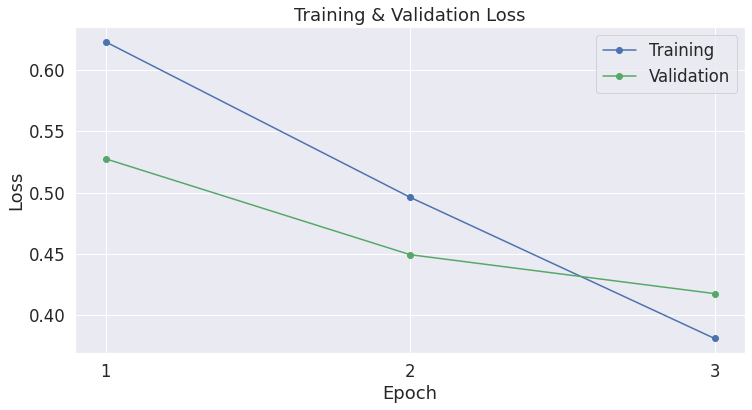

In [41]:
# Use plot styling from seaborn
sns.set(style='darkgrid')

# Increase plot and font size
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot learning curve
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label plot
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3])

plt.show()

# Performance On Test Set

## Data Preparation

In [42]:
# Load dataset into dataframe
df = pd.read_csv('test.csv',encoding='latin1', header=None)
df1 = df[[0,1]] # only columns with stories and labels
df1.columns = ['story', 'label']


# Report number of stories
print('Number of test stories: {:,}\n'.format(df.shape[0]))

# Get lists of stories and their label
stories = test['story'].values # list of all stories
labels = test['label'].values # list of all labels

# Tokenize all stories and map tokens to their word IDs
input_ids = []
attention_masks = []

# For every story...
for story in stories:
    encoded_dict = tokenizer.encode_plus(
                        story,                      # Story to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 300,           # Pad & truncate all stories
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks
                        return_tensors = 'pt',     # Return pytorch tensors
                   )
    
    # Add encoded story to list
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (differentiates padding from non-padding)
    attention_masks.append(encoded_dict['attention_mask'])

# Convert lists into tensors
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set batch size
batch_size = 32  

# Create DataLoader
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test stories: 1,105



/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


## Evaluate Model

In [43]:
# Prediction on test set

print('Predicting labels for {:,} test stories...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Tell model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 1,104 test stories...
    DONE.


In [44]:
# Combine results across all batches
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick label with higher score
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine correct labels for each batch into a single list
flat_true_labels = np.concatenate(true_labels, axis=0)

In [45]:
# Compute overall accuracy, precision, recall, f1 scores
# weighted = same as macroaveraging but with auto weights
print('Accuracy: ', accuracy_score(flat_true_labels, flat_predictions))
print('Precision: ', precision_score(flat_true_labels, flat_predictions, average='weighted', zero_division=1))
print('Recall: ', recall_score(flat_true_labels, flat_predictions, average='weighted', zero_division=1))
print('F1:', f1_score(flat_true_labels, flat_predictions, average='weighted'))

Accuracy:  0.7708333333333334
Precision:  0.7708119832177143
Recall:  0.7708333333333334
F1: 0.7708169639497252


In [46]:
# Create confusion matrix of true and predicted labels
confusion_matrix(flat_true_labels, flat_predictions)

array([[440, 125],
       [128, 411]])

In [47]:
# Compute precision, recall, fscore, support scores by category
predicted = flat_predictions
y_test = flat_true_labels

print(classification_report(y_test, predicted, digits=3))

              precision    recall  f1-score   support

           0      0.775     0.779     0.777       565
           1      0.767     0.763     0.765       539

    accuracy                          0.771      1104
   macro avg      0.771     0.771     0.771      1104
weighted avg      0.771     0.771     0.771      1104



In [48]:
# Compute Matthews correlation coefficient
matthews_corrcoef(y_test, predicted)

0.5413615870463864